<a href="https://colab.research.google.com/github/e-olang/Computer-Vision/blob/main/Maize%20Disiease%20Classifier/Notebooks/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Maize Disease

/content/drive/MyDrive/Colab Notebooks/Maize Disease


### Prep

In [ ]:
%ls

archive.zip  data/  draft1.ipynb  files/


In [ ]:
#!unzip archive.zip -d data

-----

In [ ]:
#!pip install split-folders -q

In [ ]:
#import splitfolders

In [ ]:
#splitfolders.ratio('data/', output='files', seed = 42, ratio = (.9, .1), group_prefix = None, move = False)

### Modelling

In [ ]:
import numpy as np
import os
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt

In [ ]:
import pathlib

In [ ]:
train_dir = pathlib.Path('files/train')
test_dir = pathlib.Path('files/val')

In [ ]:
print(str(len(list(train_dir.glob('*/*.jpg'))) )+ ' Training Images')
print(str(len(list(test_dir.glob('*/*.jpg')))) + ' Testing Images')

1488 Training Images
170 Testing Images


In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split = 0.1,
    subset ='training',
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 3767 files belonging to 4 classes.
Using 3391 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split = 0.1,
    subset ='validation',
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 3767 files belonging to 4 classes.
Using 376 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


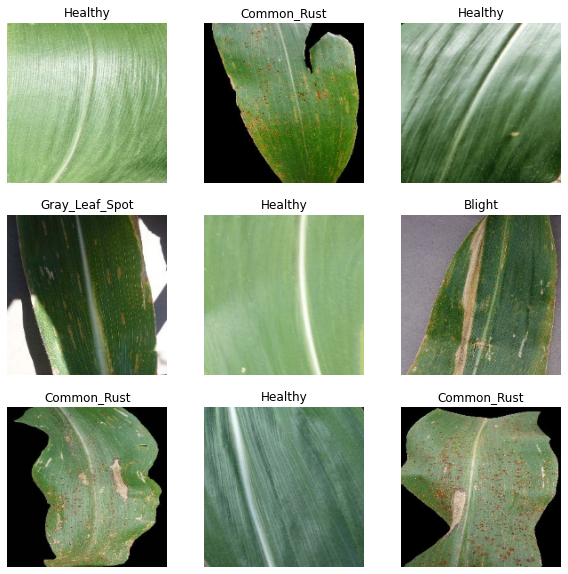

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 0.8909707


In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [ ]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs
)

Epoch 1/10
106/106 [==============================] - 48s 343ms/step - loss: 0.5643 - accuracy: 0.7694 - val_loss: 0.4151 - val_accuracy: 0.8298
Epoch 2/10
106/106 [==============================] - 2s 23ms/step - loss: 0.3391 - accuracy: 0.8587 - val_loss: 0.3687 - val_accuracy: 0.8564
Epoch 3/10
106/106 [==============================] - 2s 23ms/step - loss: 0.3174 - accuracy: 0.8643 - val_loss: 0.3467 - val_accuracy: 0.8590
Epoch 4/10
106/106 [==============================] - 2s 23ms/step - loss: 0.2490 - accuracy: 0.9009 - val_loss: 0.4108 - val_accuracy: 0.8324
Epoch 5/10
106/106 [==============================] - 2s 23ms/step - loss: 0.2056 - accuracy: 0.9189 - val_loss: 0.3006 - val_accuracy: 0.8750
Epoch 6/10
106/106 [==============================] - 2s 23ms/step - loss: 0.1736 - accuracy: 0.9339 - val_loss: 0.3075 - val_accuracy: 0.8750
Epoch 7/10
106/106 [==============================] - 2s 23ms/step - loss: 0.1153 - accuracy: 0.9584 - val_loss: 0.3091 - val_accuracy: 0.88

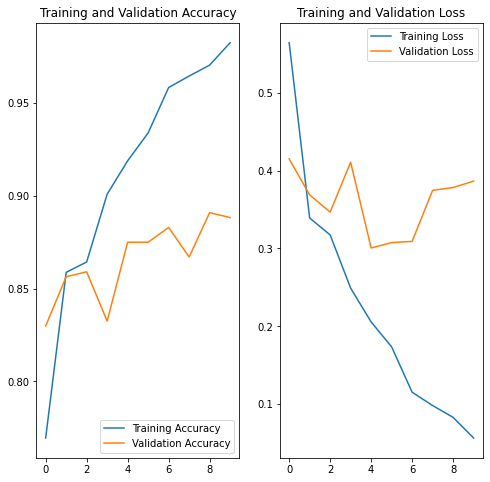

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Data augmentation

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

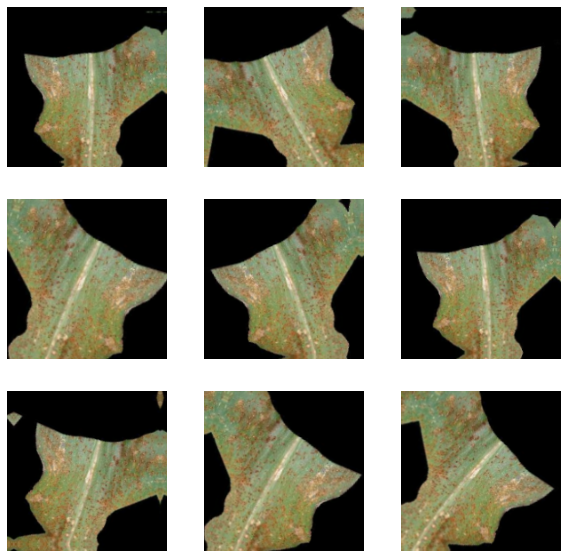

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [ ]:
epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/15
106/106 [==============================] - 4s 27ms/step - loss: 0.6460 - accuracy: 0.7364 - val_loss: 0.4724 - val_accuracy: 0.7926
Epoch 2/15
106/106 [==============================] - 3s 26ms/step - loss: 0.4068 - accuracy: 0.8298 - val_loss: 0.4122 - val_accuracy: 0.8245
Epoch 3/15
106/106 [==============================] - 3s 26ms/step - loss: 0.3833 - accuracy: 0.8464 - val_loss: 0.3723 - val_accuracy: 0.8590
Epoch 4/15
106/106 [==============================] - 3s 26ms/step - loss: 0.3339 - accuracy: 0.8649 - val_loss: 0.3694 - val_accuracy: 0.8457
Epoch 5/15
106/106 [==============================] - 3s 26ms/step - loss: 0.3097 - accuracy: 0.8720 - val_loss: 0.3802 - val_accuracy: 0.8298
Epoch 6/15
106/106 [==============================] - 3s 26ms/step - loss: 0.2986 - accuracy: 0.8800 - val_loss: 0.3471 - val_accuracy: 0.8511
Epoch 7/15
106/106 [==============================] - 3s 26ms/step - loss: 0.3275 - accuracy: 0.8697 - val_loss: 0.4064 - val_accuracy: 0.8085

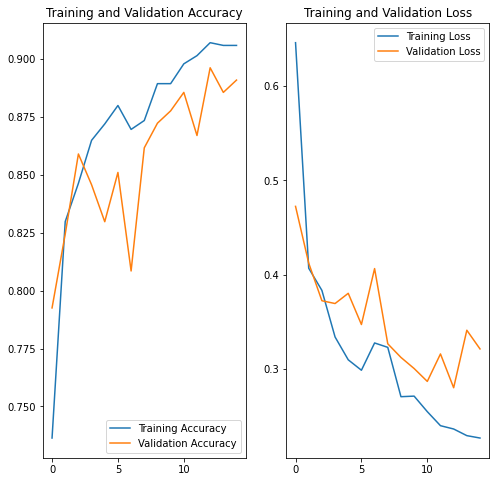

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
sunflower_path = 'files/val/Gray_Leaf_Spot/Corn_Gray_Spot (517).JPG'

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Gray_Leaf_Spot with a 99.98 percent confidence.


In [ ]:
model.save("h5_model.h5")